In [3]:
import sys
sys.path.append("/Users/satyaprk/Documents/intern_codes/robustness_vs_counterfactuals/")
sys.path.append("/Users/skrishna/Documents/phd_codes/neurips_paper/")
sys.path.append("/Users/satyaprk/Documents/intern_codes/robustness_vs_counterfactuals/Recourse_Methods/AR")
sys.path.append("/Users/satyaprk/Documents/intern_codes/robustness_vs_counterfactuals/Recourse_Methods/Generative_Model")


sys.path.append("/Users/satyaprk/Documents/intern_codes/robustness_vs_counterfactuals/Recourse_Methods/AR/recourse/")



In [4]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torch.nn as nn
import pickle as pkl
from numpy import linalg as LA
import torch.nn as nn

import ML_Models.data_loader as loader
# from utils import _get_input_subset
# from Recourse_Methods.gradient_methods import SCFE
# from utils import get_recourses, get_performance_measures


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [5]:
## Dataset Prep


from torchvision import  datasets, transforms
from torch.utils.data import DataLoader

# data_name = "compas"
data_name = "adult"
# data_name = "german"
n_starting_instances = 5000
compas_dict = {
        "data_path": '../Data_Sets/COMPAS/',
        "filename_train": 'compas-train-upsampled.csv',
        "filename_test": 'compas-test-upsampled.csv',
        "label": "risk",
        "task": "classification",
        "lr": 1e-3,
        "d": 6,
        "H1": 10,
        "H2": 10,
        "activFun": nn.Softplus(),
        "n_starting_instances": n_starting_instances
    }

german_dict = {
        "data_path": '../Data_Sets/German_Credit_Data/',
        "filename_train": 'german-train.csv',
        "filename_test": 'german-test.csv',
        "label": "credit-risk",
        "task": "classification",
        "lr": 1e-3,
        "d": 6,
        "H1": 10,
        "H2": 10,
        "activFun": nn.Softplus(),
        "n_starting_instances": n_starting_instances
    
    }

adult_dict = {
        "data_path": "../Data_Sets/Adult/",
        "filename_train": 'adult-train.csv',
        "filename_test": 'adult-test.csv',
        "label": 'income',
        "task": "classification",
        "lr": 1e-3,
        "d": 6,
        "H1": 25,
        "H2": 25,
        "activFun": nn.Softplus(),
        "n_starting_instances": n_starting_instances
    }


data_meta_dictionaries = {
        "compas": compas_dict, 
        "adult": adult_dict, 
        "german":german_dict
    }
data_meta_info = data_meta_dictionaries[data_name]


dataset_test = loader.DataLoader_Tabular(path=data_meta_info["data_path"],
                                                 filename=data_meta_info["filename_test"],
                                                 label=data_meta_info["label"], scale = "standard")
        
dataset_train = loader.DataLoader_Tabular(path=data_meta_info["data_path"],
                                                  filename=data_meta_info["filename_train"],
                                                  label=data_meta_info["label"], scale = "standard")


column_names = pd.read_csv(data_meta_info["data_path"] + data_meta_info["filename_train"]).drop(data_meta_info["label"], axis=1).columns



In [6]:


# Data loader

train_loader = DataLoader(dataset_train, batch_size = 1, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size = 1, shuffle=False)

data = [i for i in train_loader]
num_input = len(data[0][0][0])






In [7]:
epsilons = [0, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.75, 1.0]
new_epslions = [0.25, 0.3, 0.35, 0.4, 0.45]

In [21]:
# # # Train robust models with eps = 0.05, 0.1, 0.2, 0.5, 0.75, 1.0

def epoch_robust(loader, model, epsilon, opt=None):
    total_loss, total_err, total_err2 = 0.,0., 0.
    for X,y,ind in loader:
        yp = model(X.view(X.shape[0], -1).to(torch.float32))[:,0] - epsilon*(2*y.float()-1)*model.weight.norm(1)
        yp2 = model(X.view(X.shape[0], -1).to(torch.float32))[:,0]
#         loss = nn.BCEWithLogitsLoss()(yp, y.float())
#         if opt:
#             opt.zero_grad()
#             loss.backward()
#             opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_err2 += ((yp2 > 0) * (y==0) + (yp2 < 0) * (y==1)).sum().item()
#         total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_err2 / len(loader.dataset)


# def train_robust_model(epsilon, num_epochs, path_to_store_model):
#     model_robust = nn.Linear(num_input, 1)
#     opt = optim.SGD(model_robust.parameters(), lr=1e-2)
    
#     print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Err", "Rob. Test Loss", sep="\t")
#     for i in range(num_epochs):
#         train_err, train_loss = epoch_robust(train_loader, model_robust, epsilon, opt)
#         test_err, test_loss = epoch_robust(test_loader, model_robust, epsilon)
#         print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")  
    
#     torch.save(model_robust, path_to_store_model)

# num_epochs = 30
# for epsilon in new_epslions:
#     train_robust_model(epsilon, num_epochs, "./models/{}_lr_model_robust_eps_{}.pth".format(data_name, epsilon) )

  




In [14]:
# Recourse Method 2
import Recourse_Methods.Generative_Model.model as model_vae
from numpy import linalg as LA

# Second class of counter-factual explanation methods         
class CCHVAE:

    def __init__(self, classifier, model_vae, target_threshold: float = 0,
                 n_search_samples: int = 10000, p_norm: int = 2,
                 step: float = 0.05, max_iter: int = 1000, clamp: bool = True):
        
        super().__init__()
        self.classifier = classifier
        self.generative_model = model_vae
        self.n_search_samples = n_search_samples
        self.p_norm = p_norm
        self.step = step
        self.max_iter = max_iter
        self.clamp = clamp
        self.target_treshold = target_threshold

    def hyper_sphere_coordindates(self, instance, high, low):
    
        """
        :param n_search_samples: int > 0
        :param instance: numpy input point array
        :param high: float>= 0, h>l; upper bound
        :param low: float>= 0, l<h; lower bound
        :param p: float>= 1; norm
        :return: candidate counterfactuals & distances
        """
    
        delta_instance = np.random.randn(self.n_search_samples, instance.shape[1])
        dist = np.random.rand(self.n_search_samples) * (high - low) + low  # length range [l, h)
        norm_p = LA.norm(delta_instance, ord=self.p_norm, axis=1)
        d_norm = np.divide(dist, norm_p).reshape(-1, 1)  # rescale/normalize factor
        delta_instance = np.multiply(delta_instance, d_norm)
        candidate_counterfactuals = instance + delta_instance
    
        return candidate_counterfactuals, dist

    def generate_counterfactuals(self, query_instance: torch.tensor, target_class: int = 1) -> torch.tensor:
        """
        :param instance: np array
        :return: best CE
        """  #

        # init step size for growing the sphere
        low = 0
        high = low + self.step

        # counter
        count = 0
        counter_step = 1
        query_instance = query_instance.detach().numpy()

        # get predicted label of instance
        self.classifier.eval()
        instance_label = 1 - target_class
        # vectorize z
        z = self.generative_model.encode_csearch(torch.from_numpy(query_instance).float()).detach().numpy()
        z_rep = np.repeat(z.reshape(1, -1), self.n_search_samples, axis=0)
        y_cand = []
        while True:
            count = count + counter_step
            if count > self.max_iter:
                candidate_counterfactual_star = np.empty(query_instance.shape[0], )
                candidate_counterfactual_star[:] = np.nan
                distance_star = -1
                print('No CE found')
                break

            # STEP 1 -- SAMPLE POINTS on hypersphere around instance
            latent_neighbourhood, _ = CCHVAE.hyper_sphere_coordindates(self, z_rep, high, low)
            
#             print("-->> ", latent_neighbourhood)
            x_ce = self.generative_model.decode_csearch(torch.from_numpy(latent_neighbourhood).float()).detach().numpy()
            
            

            # STEP 2 -- COMPUTE l1 & l2 norms
            if self.p_norm == 1:
                distances = np.abs((x_ce - query_instance)).sum(axis=1)
            elif self.p_norm == 2:
                distances = LA.norm(x_ce - query_instance, axis=1)
            else:
                print('Distance not defined yet')
            
            # counterfactual labels
#             print(self.classifier(torch.from_numpy(x_ce).float()).detach().numpy())
            y_cand.extend([int(i[0]) for i in self.classifier(torch.from_numpy(x_ce).float()).detach().numpy() > 0])
            y_candidate = torch.stack([torch.tensor([int(i[0])]) for i in self.classifier(torch.from_numpy(x_ce).float()).detach().numpy() > 0])
            
#             print("Y_Cands : ", self.classifier(torch.from_numpy(x_ce).float()).detach().numpy().mean())
            indeces = np.where(y_candidate != instance_label)[0]
#             print("Indeces : ", indeces)
            candidate_counterfactuals = x_ce[indeces]
            candidate_dist = distances[indeces]
            
            if len(candidate_dist) == 0:  # no candidate found & push search range outside
                low = high
                high = low + self.step
            elif len(candidate_dist) > 0:  # certain candidates generated
                min_index = np.argmin(candidate_dist)
                candidate_counterfactual_star = candidate_counterfactuals[min_index]
                distance_star = np.abs(candidate_counterfactual_star - query_instance).sum()
                break

        return y_cand, torch.tensor(candidate_counterfactual_star), torch.tensor(distance_star)
#         return  torch.tensor(distance_star)     
    
    
# Recourse Method -1 
import torch
import numpy as np
from torch import nn
import datetime


class SCFE:
    
    def __init__(self, classifier, target_threshold: float = 0, _lambda: float = 10.0,
                 lr: float = 0.1, max_iter: int = 500, t_max_min: float = 0.5,
                 step: float = 0.10, norm: int = 2, optimizer: str = 'adam'):
        
        super().__init__()
        self.model_classification = classifier
        self.lr = lr
        self.max_iter = max_iter
        self.optimizer = optimizer
        self.t_max_min = t_max_min
        self.norm = norm
        self.sigmoid = nn.Sigmoid()
        self.target_thres = target_threshold
        self._lambda = _lambda
        self.step = step
    
    def generate_counterfactuals(self, query_instance: torch.tensor, target_class: int = 1) -> torch.tensor:
        """
            query instance: the point to be explained
            target_class: Direction of the desired change. If target_class = 1, we aim to improve the score,
                if target_class = 0, we aim to decrese it (in classification and regression problems).
            _lambda: Lambda parameter (distance regularization) parameter of the problem
        """
        
        if target_class == 1:
            target_prediction = torch.tensor(1).float()
        else:
            target_prediction = torch.tensor(0).float()
        
        output = self._call_model(query_instance.reshape(1, -1))
        output = self._call_model(query_instance)
        
        cf = query_instance.clone().requires_grad_(True)
        
        if self.optimizer == 'adam':
            optim = torch.optim.Adam([cf], self.lr)
        else:
            optim = torch.optim.RMSprop([cf], self.lr)
        
        # Timer
        t0 = datetime.datetime.now()
        t_max = datetime.timedelta(minutes=self.t_max_min)
        
        counterfactuals = []
        while not self._check_cf_valid(output, target_class):
#             print("in...")
            iter = 0
            distances = []
            all_loss = []
            while not self._check_cf_valid(output, target_class) and iter < self.max_iter:
                cf.requires_grad = True
                total_loss, loss_distance = self.compute_loss(self._lambda, cf,
                                                              query_instance,
                                                              target_prediction)
                optim.zero_grad()
                total_loss.backward(retain_graph=True)
                optim.step()
                
                output = self._call_model(cf)
                
                if self._check_cf_valid(output, target_class):
                    counterfactuals.append(cf.detach())
                    distances.append(loss_distance.clone().detach())
                    all_loss.append(total_loss.detach())
                
                iter = iter + 1
            
            output = self._call_model(cf).reshape(1, -1).detach()
            if datetime.datetime.now() - t0 > t_max:
                break

            if self.step == 0.0:  # Don't search over lambdas
                break
            else:
                self._lambda -= self.step

        if not len(counterfactuals):
            print('No CE found')
            return torch.tensor(-1.0)
#             cf.detach_()
            
        
        # Choose the nearest counterfactual
        counterfactuals = torch.stack(counterfactuals)
        distances = torch.stack(distances)
        distances = distances.detach()
        index = torch.argmin(distances)
        counterfactuals = counterfactuals.detach()

        ce_star = counterfactuals[index]
        distance_star = distances[index]
        
        
        return ce_star, distance_star
#         return distance_star

    
    def compute_loss(self, _lambda: float, cf_candidate: torch.tensor, original_instance: torch.tensor,
                     target: torch.tensor) -> torch.tensor:
        output = self._call_model(cf_candidate)
        # classification loss
        bce_loss = nn.BCEWithLogitsLoss()
#         print("Testing code : " , output, target)
        loss_classification = bce_loss(output, target)
        # distance loss
        loss_distance = torch.norm((cf_candidate - original_instance), self.norm)
        # full loss
        total_loss = loss_classification + _lambda * loss_distance
        return total_loss, loss_distance

    def _call_model(self, cf_candidate):
        output = self.model_classification(cf_candidate)[0]
#         print(output)
        return output

    def _check_cf_valid(self, output, target_class):
        """ Check if the output constitutes a sufficient CF-example.
            target_class = 1 in general means that we aim to improve the score,
            whereas for target_class = 0 we aim to decrese it.
        """
        if target_class == 1:
            check = output >= self.target_thres
            return check
        else:
            check = output <= self.target_thres
            return check
        
        

In [15]:
def _get_input_subset(model_sub, inputs: torch.tensor,
                      subset_size: int = 100,
                      decision_threshold: float = 0) -> torch.tensor:
    
    """
    Get negatively classified inputs & return their predictions
    """
    
    yhat = (model_sub(inputs) > decision_threshold) * 1
    check = (model_sub(inputs) < decision_threshold).detach().numpy()
    selected_indices = np.where(check)[0]
    input_subset = inputs[selected_indices]
    predicted_label_subset = yhat[selected_indices]
    print("Total eligible samples : ", input_subset.shape)
#     return input_subset, predicted_label_subset
    return input_subset[0:subset_size], predicted_label_subset[0:subset_size] #[0:subset_size] #[0:subset_size]



In [20]:
import numpy as np
import pandas as pd
from numpy import linalg as LA

# from carla import log


def hyper_sphere_coordindates(n_search_samples, instance, high, low, p_norm=1):

    # Implementation follows the Random Point Picking over a sphere
    # The algorithm's implementation follows: Pawelczyk, Broelemann & Kascneci (2020);
    # "Learning Counterfactual Explanations for Tabular Data" -- The Web Conference 2020 (WWW)
    # It ensures that points are sampled uniformly at random using insights from:
    # http://mathworld.wolfram.com/HyperspherePointPicking.html

    # This one implements the growing spheres method from
    # Thibaut Laugel et al (2018), "Comparison-based Inverse Classification for
    # Interpretability in Machine Learning" -- International Conference on Information Processing
    # and Management of Uncertainty in Knowledge-Based Systems (2018)

    """
    :param n_search_samples: int > 0
    :param instance: numpy input point array
    :param high: float>= 0, h>l; upper bound
    :param low: float>= 0, l<h; lower bound
    :param p: float>= 1; norm
    :return: candidate counterfactuals & distances
    """

    delta_instance = np.random.randn(n_search_samples, instance.shape[1])
    dist = np.random.rand(n_search_samples) * (high - low) + low  # length range [l, h)
    norm_p = LA.norm(delta_instance, ord=p_norm, axis=1)
    d_norm = np.divide(dist, norm_p).reshape(-1, 1)  # rescale/normalize factor
    delta_instance = np.multiply(delta_instance, d_norm)
    candidate_counterfactuals = instance + delta_instance

    return candidate_counterfactuals, dist


def growing_spheres_search(
    instance,
    keys_mutable,
    keys_immutable,
    continuous_cols,
    binary_cols,
    feature_order,
    model,
    n_search_samples=2000,
    p_norm=2,
    step=0.01,
    max_iter=1000,
):

    """
    :param instance: df
    :param step: float > 0; step_size for growing spheres
    :param n_search_samples: int > 0
    :param model: sklearn classifier object
    :param p_norm: float=>1; denotes the norm (classical: 1 or 2)
    :param max_iter: int > 0; maximum # iterations
    :param keys_mutable: list; list of input names we can search over
    :param keys_immutable: list; list of input names that may not be searched over
    :return:
    """  #

    # correct order of names
    keys_correct = feature_order
    # divide up keys
    keys_mutable_continuous = list(set(keys_mutable) - set(binary_cols))
    keys_mutable_binary = list(set(keys_mutable) - set(continuous_cols))

    # Divide data in 'mutable' and 'non-mutable'
    # In particular, divide data in 'mutable & binary' and 'mutable and continuous'
    instance_immutable_replicated = np.repeat(
        instance[keys_immutable].values.reshape(1, -1), n_search_samples, axis=0
    )
    instance_replicated = np.repeat(
        instance.values.reshape(1, -1), n_search_samples, axis=0
    )
    instance_mutable_replicated_continuous = np.repeat(
        instance[keys_mutable_continuous].values.reshape(1, -1),
        n_search_samples,
        axis=0,
    )
    # instance_mutable_replicated_binary = np.repeat(
    #     instance[keys_mutable_binary].values.reshape(1, -1), n_search_samples, axis=0
    # )

    # init step size for growing the sphere
    low = 0
    high = low + step

    # counter
    count = 0
    counter_step = 1

    # get predicted label of instance
#     print("--->", torch.tensor(instance.values), torch.from_numpy(instance.values).float())
    instance_label = np.argmax(model(torch.from_numpy(instance.values).float()).detach())

    counterfactuals_found = False
    candidate_counterfactual_star = np.empty(
        instance_replicated.shape[1],
    )
    candidate_counterfactual_star[:] = np.nan
    while not counterfactuals_found or count > max_iter:
        count = count + counter_step

        # STEP 1 -- SAMPLE POINTS on hyper sphere around instance
        candidate_counterfactuals_continuous, _ = hyper_sphere_coordindates(
            n_search_samples, instance_mutable_replicated_continuous, high, low, p_norm
        )

        # sample random points from Bernoulli distribution
        candidate_counterfactuals_binary = np.random.binomial(
            n=1, p=0.5, size=n_search_samples * len(keys_mutable_binary)
        ).reshape(n_search_samples, -1)

        # make sure inputs are in correct order
        candidate_counterfactuals = pd.DataFrame(
            np.c_[
                instance_immutable_replicated,
                candidate_counterfactuals_continuous,
                candidate_counterfactuals_binary,
            ]
        )
        candidate_counterfactuals.columns = (
            keys_immutable + keys_mutable_continuous + keys_mutable_binary
        )
        # enforce correct order
        candidate_counterfactuals = candidate_counterfactuals[keys_correct]

        # STEP 2 -- COMPUTE l_1 DISTANCES
        if p_norm == 1:
            distances = np.abs(
                (candidate_counterfactuals.values - instance_replicated)
            ).sum(axis=1)
        elif p_norm == 2:
            distances = np.square(
                (candidate_counterfactuals.values - instance_replicated)
            ).sum(axis=1)
        else:
            raise ValueError("Distance not defined yet")

        # counterfactual labels
        y_candidate_logits = model(torch.from_numpy(instance.values).float()).detach().numpy()
        y_candidate = np.argmax(y_candidate_logits, axis=1)
        indeces = np.where(y_candidate != instance_label)
        candidate_counterfactuals = candidate_counterfactuals.values[indeces]
        candidate_dist = distances[indeces]

        if len(candidate_dist) > 0:  # certain candidates generated
            min_index = np.argmin(candidate_dist)
            candidate_counterfactual_star = candidate_counterfactuals[min_index]
            counterfactuals_found = True

        # no candidate found & push search range outside
        low = high
        high = low + step
        
        if p_norm == 1:
                distances = np.abs((instance.values - candidate_counterfactual_star)).sum(axis=1)
        elif p_norm == 2:
                distances = LA.norm(instance.values - candidate_counterfactual_star, axis=1)

    return candidate_counterfactual_star, distances


In [21]:
# model_robust = torch.load("./models/{}_lr_model_robust_eps_{}.pth".format(data_name, 0.5))
# test_loader = DataLoader(dataset_test, batch_size = 32, shuffle=False)
# subset_size = 1
# data_iter = iter(test_loader)
# inputs, labels, indeces = data_iter.next()
# inputs = inputs.float()
# inputs, predicted_classes = _get_input_subset(model_robust, inputs, subset_size, decision_threshold=0)
# print(inputs.shape)
# inputs_pd = pd.DataFrame(inputs.numpy(), columns = column_names)
# print(inputs_pd)

# cfes = growing_spheres_search(instance = inputs_pd ,keys_mutable =column_names,  keys_immutable=[], 
#                        continuous_cols= column_names,binary_cols = [] , feature_order = column_names, model = model_robust)



In [24]:
def get_cchvae_explanations(model_bb, epsilon, subset_size, path_to_dump):
    test_loader = DataLoader(dataset_test, batch_size = data_meta_info["n_starting_instances"], shuffle=False)
    data_iter = iter(test_loader)
    inputs, labels, indeces = data_iter.next()
    inputs = inputs.float()
    inputs, predicted_classes = _get_input_subset(model_bb, inputs, subset_size, decision_threshold=0)
    vae_path = "../Recourse_Methods/Generative_Model/Saved_Models/"

    input_size = dataset_train.get_number_of_features()
    vae_model = model_vae.VAE_model(input_size,
                                data_meta_info['activFun'],
                                data_meta_info['d'],
                                data_meta_info['H1'],
                                data_meta_info['H2'])

    data_meta_info["vae_path"] = vae_path + f"vae_{data_name}.pt"
    vae_model.load_state_dict(torch.load(data_meta_info["vae_path"]))
    cchvae = CCHVAE(classifier=model_bb, model_vae=vae_model, step=1.3, max_iter=20000, target_threshold=0)
    distances_cchave = []
    for i in range(len(inputs)):
        if i%100 == 0 and i!= 0:
            print(sum([i[1] for i in distances_cchave])/len(distances_cchave))            
            print("Gotten {} done...".format(i))
        y_val, ctr_cfe, ctr_val,  = cchvae.generate_counterfactuals(
                    query_instance= inputs[i].reshape(1, -1),
                    target_class= 1 )
        if ctr_val.item() > 0:
            distances_cchave.append([inputs[i].unsqueeze(0).numpy(), ctr_cfe, ctr_val])

    import pickle as pkl
    pkl.dump(distances_cchave, open(path_to_dump, "wb"))
    
    
def get_scfe_explanations(model_bb, epsilon, subset_size, path_to_dump):
    test_loader = DataLoader(dataset_test, batch_size = data_meta_info["n_starting_instances"], shuffle=False)
    data_iter = iter(test_loader)
    inputs, labels, indeces = data_iter.next()
    inputs = inputs.float()
    inputs, predicted_classes = _get_input_subset(model_bb, inputs, subset_size, decision_threshold=0)

    scfe = SCFE(classifier=model_bb, lr=1e-3, _lambda=0.00, step=0.00, max_iter=10000, target_threshold=0)
    distances_scfe = []
    for i in range(len(inputs)):
        if i%100 == 0 and i!= 0:
            print(sum([i[1] for i in distances_scfe])/len(distances_scfe))            
            print("Gotten {} done...".format(i))
        ctr_cfe, ctr_val,  = scfe.generate_counterfactuals(
                    query_instance=inputs[i],
                    target_class=1)
        if ctr_val.item() > 0:
            distances_scfe.append([inputs[i].unsqueeze(0).numpy(), ctr_cfe, ctr_val])

    import pickle as pkl
    pkl.dump(distances_scfe, open(path_to_dump, "wb"))
    
    

def get_gsm_explanations(model_bb, epsilon, subset_size, path_to_dump):
    test_loader = DataLoader(dataset_test, batch_size = data_meta_info["n_starting_instances"], shuffle=False)
    data_iter = iter(test_loader)
    inputs, labels, indeces = data_iter.next()
    inputs = inputs.float()
    inputs, predicted_classes = _get_input_subset(model_bb, inputs, subset_size, decision_threshold=0)
    distances_gsm = []
    for i in range(len(inputs)):
        if i%100 == 0 and i != 0:
            print("-->", len(distances_gsm))
            print("-->2", sum([i[1][0] for i in distances_gsm])/len(distances_gsm))
        instance = pd.DataFrame(inputs[i].unsqueeze(0).numpy(), columns = column_names)
        cfe, cfe_d = growing_spheres_search(instance = instance ,keys_mutable =column_names,  keys_immutable=[], 
                       continuous_cols= column_names,binary_cols = [] , feature_order = column_names, model = model_bb)
        distances_gsm.append([inputs[i].unsqueeze(0).numpy(), cfe, cfe_d])
        
    import pickle as pkl
    pkl.dump(distances_gsm, open(path_to_dump, "wb"))
    


    

In [25]:
subset_size = 200
for epsilon in epsilons:
    model_rob = torch.load("./models/{}_lr_model_robust_eps_{}.pth".format(data_name, epsilon))
    get_gsm_explanations(model_rob, epsilon, subset_size, "./explanations/{}_base_gsm_standard_{}_small.pkl".format(data_name, epsilon))
    get_cchvae_explanations(model_rob, epsilon, subset_size, "./explanations/{}_base_cchvae_standard_{}_small.pkl".format(data_name, epsilon))
    get_scfe_explanations(model_rob, epsilon, subset_size, "./explanations/{}_base_scfe_standard_{}_small.pkl".format(data_name, epsilon))
    
    
    
    

Total eligible samples :  torch.Size([4014, 13])
--> 100
-->2 -0.18637855998628544
Total eligible samples :  torch.Size([4014, 13])
tensor([ 0.0688, -1.1050,  0.1869, -0.9323, -1.2803,  0.0316,  1.4812,  0.3539,
        -3.8669,  0.2327, -6.1748,  1.0789,  1.2863])
Gotten 100 done...
Total eligible samples :  torch.Size([4014, 13])
tensor([ 0.2058,  0.5176,  0.0941,  0.2822,  0.2642,  0.2084,  0.2375,  0.5648,
        -0.1068, -0.3445,  0.6222,  0.2719,  0.2367])
Gotten 100 done...
Total eligible samples :  torch.Size([4196, 13])
--> 100
-->2 -0.17794226817935738
Total eligible samples :  torch.Size([4196, 13])
tensor([-0.2035, -0.8200,  0.1837, -0.9652, -0.9194, -0.0813,  1.2351,  0.4016,
        -2.2580,  0.0745, -3.2549,  0.7727,  0.9341])
Gotten 100 done...
Total eligible samples :  torch.Size([4196, 13])
tensor([ 0.4206,  0.6883,  0.3562,  0.5252,  0.4706,  0.4349,  0.3795,  0.7713,
        -0.3735, -0.6112, -0.3686,  0.4501,  0.4432])
Gotten 100 done...
Total eligible samples :  

In [13]:
# Plot 1 : epsilon goes from 0.05 to 1; yaxis: accuracy of robust model on test set
# test_loader = DataLoader(dataset_test, batch_size = 1, shuffle=False)
test_accuracies_adv = []
test_accuracies = []
for epsilon in epsilons:
    test_loader = DataLoader(dataset_test, batch_size = 1, shuffle=False)
    model_robust = torch.load("./models/{}_lr_model_robust_eps_{}.pth".format(data_name, epsilon))
    test_acc, test_acc2 = epoch_robust(test_loader, model_robust, epsilon)
    test_accuracies_adv.append(1-test_acc)
    test_accuracies.append(1-test_acc2)


import seaborn
df = pd.DataFrame({
    'epsilon': epsilons,
    'Adversarial samples' : test_accuracies_adv, 
    'Test dataset' : test_accuracies


})
# fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = df.melt(id_vars='epsilon').rename(columns=str.title)
tidy["Samples"] = tidy["Variable"]
tidy["Accuracy"] = tidy["Value"]
# tidy = tidy.rename(columns={"Variable", "Method"})
# seaborn.barplot(x='Epsilon', y='Difference', hue='Method', data=tidy, ax=ax1)

fig, ax1 = plt.subplots(figsize=(10, 10))
p= seaborn.lineplot(data=tidy, x="Epsilon", y="Accuracy", hue="Samples" , style="Samples", markers=True, dashes=False)
p.set_xlabel("Epsilon", fontsize = 20)
p.set_ylabel("Accuracy", fontsize = 20)
p.legend(labels=['Adversarial samples','Test dataset'], fontsize = 20)
plt.xticks(epsilons[2:], rotation = -50)
seaborn.despine(fig)
fig.savefig("test_accuracy_adv.png") 

KeyboardInterrupt: 

In [14]:
plt.rcParams["figure.figsize"] = [11.50, 3.50]
plt.plot(epsilons, test_accuracies, 'o-b')
plt.ylabel("Accuracy")
plt.xlabel("epsilon")
plt.xticks([i for i in epsilons], rotation=-50)
# xticks(np.arange(3), ['Tom', 'Dick', 'Sue'])
plt.title("Test Accuracies of robust models trained on {} dataset".format(data_name))
plt.savefig("model_test_accuracy.png")

In [27]:
# Plot 3 (a)
import pickle as pkl
from sklearn.preprocessing import MinMaxScaler, StandardScaler
costs_cchvae = []
costs_scfe = []
costs_gsm = []

base_costs_cchvae = pkl.load(open("./explanations/{}_base_cchvae_standard_{}.pkl".format(data_name, 0), "rb"))
base_costs_scfe = pkl.load(open("./explanations/{}_base_scfe_standard_{}.pkl".format(data_name, 0), "rb"))
base_costs_gsm = pkl.load(open("./explanations/{}_base_gsm_standard_{}.pkl".format(data_name, 0), "rb"))

base_costs_cchvae = np.array([i[1] for i in base_costs_cchvae])
base_costs_scfe = np.array([i[1] for i in base_costs_scfe])
base_costs_gsm = np.array([i[1] for i in base_costs_gsm])

# 3a
# for epsilon in epsilons[1:]:
#     print(epsilon)
#     cfe_cchvae = pkl.load(open("./explanations/{}_base_cchvae_standard_{}.pkl".format(data_name, epsilon), "rb"))
#     print(len(cfe_cchvae), len(base_costs_cchvae), len([i[1] for i in cfe_cchvae][:base_costs_cchvae.shape[0]]))
    
#     costs_cchvae.append(np.mean(np.array([i[1] for i in cfe_cchvae]) - base_costs_cchvae[:len(cfe_cchvae)]))
#     cfe_scfe = pkl.load(open("./explanations/{}_base_scfe_standard_{}.pkl".format(data_name, epsilon), "rb"))
#     costs_scfe.append(np.mean(np.array([i[1] for i in cfe_scfe]) - base_costs_scfe[:len(cfe_scfe)]))
#     cfe_gsm = pkl.load(open("./explanations/{}_base_gsm_standard_{}.pkl".format(data_name, epsilon), "rb"))
#     costs_gsm.append(np.mean(np.mean(np.array([i[1] for i in cfe_gsm]) - base_costs_gsm[:len(cfe_gsm)])))
 
# Theoretical Bound for SCFE



#3_b    
# for epsilon in epsilons[1:]:
#     print(epsilon)
#     cfe_cchvae = pkl.load(open("./explanations/{}_base_cchvae_standard_{}.pkl".format(data_name, epsilon), "rb"))  
#     min_samples = min(len(base_costs_cchvae), len(cfe_cchvae))
#     costs_cchvae.append(np.mean(((np.array([i[1].item() for i in cfe_cchvae[:min_samples]]) - base_costs_cchvae[:min_samples]))/base_costs_cchvae[:min_samples]))
#     cfe_scfe = pkl.load(open("./explanations/{}_base_scfe_standard_{}.pkl".format(data_name, epsilon), "rb"))
    
#     min_samples = min(len(base_costs_scfe), len(cfe_scfe))
#     costs_scfe.append(np.mean(((np.array([i[1] for i in cfe_scfe[:min_samples]]) - base_costs_scfe[:min_samples]))/base_costs_scfe[:min_samples]))
#     cfe_gsm = pkl.load(open("./explanations/{}_base_gsm_standard_{}.pkl".format(data_name, epsilon), "rb"))
    
#     min_samples = min(len(base_costs_gsm), len(cfe_gsm))
#     costs_gsm.append(np.mean(((np.array([i[1] for i in cfe_gsm[:min_samples]]) - base_costs_gsm[:min_samples]))/base_costs_gsm[:min_samples]))

# print(costs_gsm, costs_scfe, costs_cchvae)

# Theoretical Values. 
def sigmoid(val):
    return 1/(1+np.exp(-1 * val))

def sign_of(w):
    return np.sign(w)

def theoretical_bound_scfe(x, model, model_robust, learning_rate, weights_base, weights_robust, epsilon, lambda_val):
    m = (1/(2*learning_rate)) - lambda_val
    k = model(x).item()
    k_prime = model_robust(x).item()
#     print("K prime : ", k_prime, "K - K' : ", (k - k_prime))
#     print("K : ", k)
#     print("m : ", m)
#     print("l2 weight base : ", LA.norm(weights_base))
    first_term = np.abs((k - k_prime))*(LA.norm(weights_base))
    second_term = learning_rate*np.abs((k_prime - 1))*np.abs((k - k_prime + epsilon*np.abs(weights_robust).sum(axis=0).item()))*LA.norm(x)
    third_term = learning_rate*epsilon*np.abs((k_prime - 1))*np.abs((sigmoid(k_prime-epsilon*np.abs(weights_robust).sum(axis=0).item()) - 1))*LA.norm(sign_of(weights_robust))
#     print("first : ", first_term)
#     print("second : ", second_term)
#     print("third : ", third_term)
#     return (1/m)*(first_term+second_term+third_term)
    return (first_term+second_term+third_term)


def get_diffs_theory(input_sample, model, model_robust, epsilon):                
    w_b = model.weight.detach().squeeze(0).numpy()
    w_r = model_robust.weight.detach().squeeze(0).numpy()
    lambda_val = 0.0
    lr=1e-1
    return theoretical_bound_scfe(input_sample, model, model_robust, lr, w_b, w_r, epsilon, lambda_val)
    



def get_diffs(costs, path_name):
    costs_out = []
    scaler = MinMaxScaler()
#     for i in range(1, len(costs)):
#         costs_out.append(costs[i] - costs[0])
    costs_df = pd.DataFrame(zip(costs, epsilons[1:]), columns=["cost","epsilon" ])
    costs_df[['cost']] = scaler.fit_transform(costs_df[['cost']])
    costs_df[['cost']].to_csv(path_name, index = False)
    return []
    



In [28]:
theory_bound = []
model = torch.load("./models/{}_lr_model_robust_eps_{}.pth".format(data_name, 0))
subset_size = 2500
for epsilon in epsilons[1:2]:
    bound_per_epsilon = []
    model_robust = torch.load("./models/{}_lr_model_robust_eps_{}.pth".format(data_name, epsilon))
    test_loader = DataLoader(dataset_test, batch_size = 2500, shuffle=False)
    data_iter = iter(test_loader)
    inputs, labels, indeces = data_iter.next()
    inputs = inputs.float()
    print(inputs[0])
    inputs, predicted_classes = _get_input_subset(model_robust, inputs, subset_size, decision_threshold=0)
    for i in inputs:
        bound_per_epsilon.append(get_diffs_theory(i, model, model_robust, epsilon))
    theory_bound.append(sum(bound_per_epsilon)/len(bound_per_epsilon))
    
    

tensor([-0.8682,  0.0661, -0.4451, -0.1476, -0.2200, -1.7371,  0.6828,  0.6025,
         0.9271,  0.9114,  0.8393, -2.4053,  0.3074])
Total eligible samples :  torch.Size([2097, 13])


In [86]:
np.median(bound_per_epsilon)

1.6640000035937799

In [80]:
bound_per_epsilon[:10]

[3.84219975244437,
 3.1513687337585683,
 4.376414190423487,
 4.24580558388284,
 3.8881984226273767,
 1.9840118551702153,
 1.3162700970840964,
 3.0957021903458006,
 2.092390027133667,
 0.5970600228788172]

In [70]:
np.std(bound_per_epsilon)


1.94459839621855

In [40]:
import pickle as pkl
exp_bound = []
exp_base = pkl.load(open("./explanations/{}_base_scfe_standard_{}_small.pkl".format(data_name, 0), "rb"))
exp_base = [i[1] for i in exp_base]
subset_size = 2500
for epsilon in epsilons[1:2]:
    #print(epsilon,exp_ro[0], exp_base[0])
    exp_ro = pkl.load(open("./explanations/{}_base_scfe_standard_{}_small.pkl".format(data_name, epsilon), "rb"))
    inputs = set([tuple(i[0]) for i in exp_ro]).intersection([tuple(i[0]) for i in exp_base])
    
#     print(exp_base, exp_ro)
    
    bound_per_epsilon = [LA.norm(exp_ro[i]-exp_base[i], axis=0) for i in exp_ro if i[0] in inputs ]

    exp_bound.append(sum(bound_per_epsilon)/len(bound_per_epsilon))
    

TypeError: unhashable type: 'numpy.ndarray'

In [34]:
np.median(bound_per_epsilon)

4.5927353

In [60]:
np.std(bound_per_epsilon)

1.3141149

In [59]:
exp_ro[0]-exp_base[0]

tensor([ 0.3314,  0.3314,  0.3314,  0.3314,  0.3314,  0.3314,  0.3314,  0.3314,
        -0.3314, -0.3314, -1.6405,  0.3314,  0.3314])

In [27]:
exp_bound

[4.603578971310829,
 5.062529573308787,
 5.655468427948728,
 6.147100105541536,
 7.366158591588593,
 12.49535018403768,
 9.346126778105711,
 12.76314493690341,
 26.3620404780842,
 27.61551994565109,
 23.184508953094483]

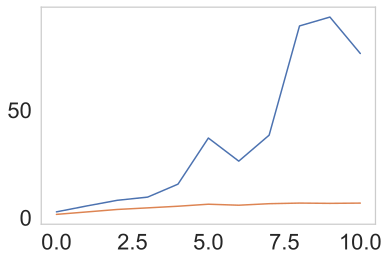

In [211]:
plt.plot(range(len(exp_bound)),exp_bound, theory_bound)

In [47]:
# costs_cchvae = get_diffs(costs_cchvae, "./explanations/costs_cchvae_df_{}.csv".format(data_name))
# costs_scfe = get_diffs(costs_scfe, "./explanations/costs_scfe_df_{}.csv".format(data_name))
# costs_gsm = get_diffs(costs_gsm, "./explanations/costs_gsm_df_{}.csv".format(data_name))


# costs_cchvae = get_diffs(costs_cchvae, "./explanations/costs_cchvae_df_{}_3_b.csv".format(data_name))
# costs_scfe = get_diffs(costs_scfe, "./explanations/costs_scfe_df_{}_3_b.csv".format(data_name))
# costs_gsm = get_diffs(costs_gsm, "./explanations/costs_gsm_df_{}_3_b.csv".format(data_name))




In [56]:
# Plot 4

valids_cchvae = []
valids_scfe = []
valids_gsm = []

base_costs_cchvae = pkl.load(open("./explanations/{}_base_cchvae_standard_{}.pkl".format(data_name, 0), "rb"))
base_costs_scfe = pkl.load(open("./explanations/{}_base_scfe_standard_{}.pkl".format(data_name, 0), "rb"))
base_costs_gsm = pkl.load(open("./explanations/{}_base_gsm_standard_{}.pkl".format(data_name, 0), "rb"))

base_cfe_cchvae = [i[0] for i in base_costs_cchvae]
base_cfe_scfe = [i[0] for i in base_costs_scfe]
base_cfe_gsm = [torch.tensor(i[0], dtype= torch.float32) for i in base_costs_gsm]
print(base_cfe_gsm[:10])

for epsilon in epsilons[1:]:
    print(epsilon)
    model_robust = torch.load("./models/{}_lr_model_robust_eps_{}.pth".format(data_name, epsilon))
    valids_cchvae.append((sum([model_robust(i)>0 for i in base_cfe_cchvae])/len(base_cfe_cchvae)).item())
    valids_scfe.append((sum([model_robust(i)>0 for i in base_cfe_scfe])/len(base_cfe_scfe)).item())
    valids_gsm.append((sum([model_robust(i)>0 for i in base_cfe_gsm])/len(base_cfe_gsm)).item())
    
    
#     cfe_cchvae = pkl.load(open("./explanations/{}_base_cchvae_standard_{}.pkl".format(data_name, epsilon), "rb"))    
#     costs_cchvae.append(np.mean(((np.array([i[1] for i in cfe_cchvae]) - base_costs_cchvae[:len(cfe_cchvae)]))/base_costs_cchvae[:len(cfe_cchvae)]))
#     cfe_scfe = pkl.load(open("./explanations/{}_base_scfe_standard_{}.pkl".format(data_name, epsilon), "rb"))
#     costs_scfe.append(np.mean(((np.array([i[1] for i in cfe_scfe]) - base_costs_scfe[:len(cfe_scfe)]))/base_costs_scfe[:len(cfe_scfe)]))
#     cfe_gsm = pkl.load(open("./explanations/{}_base_gsm_standard_{}.pkl".format(data_name, epsilon), "rb"))
#     costs_gsm.append(np.mean(((np.array([i[1] for i in cfe_gsm]) - base_costs_gsm[:len(cfe_gsm)]))/base_costs_gsm[:len(cfe_gsm)]))
    


[tensor([-0.8679,  0.0660, -0.4459, -0.1480, -0.2186, -1.7365,  0.6839,  0.6036,
         0.9267,  0.9116,  0.8395, -2.4066,  0.3072]), tensor([-0.1127, -0.8390,  0.7477, -0.1474, -0.2196, -0.9006, -1.4643,  0.6025,
         0.9267,  0.9114,  0.8393,  0.4163,  0.3070]), tensor([-1.0195, -0.0039, -0.4451, -0.1476, -0.2200, -0.0633, -1.4646,  0.6026,
         0.9271,  0.9113,  0.8393,  0.4158,  0.3074]), tensor([-0.6414,  0.5651, -0.8423, -0.1474, -0.2199, -0.0632, -1.4652,  0.6022,
         0.9273,  0.9114,  0.8393,  0.4160,  0.3075]), tensor([-0.0371,  0.2248,  0.7470, -0.1475, -0.2200, -0.9002, -1.4648,  0.6024,
         0.9273,  0.9112,  0.8384, -2.4052,  0.3074]), tensor([ 0.2650,  0.3293,  1.5425, -0.1475, -0.2206, -0.0637,  0.6820, -1.6601,
         0.9265, -1.0981,  0.8382,  0.4168,  0.3090]), tensor([-0.1135,  1.7218, -0.0482, -0.1476, -0.2201, -0.0628,  0.6832,  0.6029,
         0.9258, -1.0964,  0.8394, -2.4063,  0.3077]), tensor([-1.1709,  0.3672, -0.4452, -0.1473, -0.2205, -

In [53]:
costs_scfe

[0.025230275467038155,
 0.007208650466054678,
 0.008410092443227768,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [54]:
costs_cchvae

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.021199999377131462,
 0.4860000014305115,
 0.005200000014156103,
 0.0,
 0.0,
 0.0]

In [58]:
def get_diffs_validity(costs, path_name):
    costs_out = []
#     scaler = StandardScaler()
    costs_df = pd.DataFrame(zip(costs, epsilons[1:]), columns=["validity","epsilon" ])
    costs_df[['validity']].to_csv(path_name, index = False)
    return costs_out

def get_diffs_costs(costs, path_name):
    costs_out = []
#     scaler = StandardScaler()
    costs_df = pd.DataFrame(zip(costs, epsilons[1:]), columns=["cost","epsilon" ])
    costs_df[['cost']].to_csv(path_name, index = False)
    return costs_out


# costs_cchvae = get_diffs_validity(valids_cchvae, "./explanations/valids_cchvae_df_{}_3_b.csv".format(data_name))
# costs_scfe = get_diffs_validity(valids_scfe, "./explanations/valids_scfe_df_{}_3_b.csv".format(data_name))
# costs_gsm = get_diffs_validity(valids_gsm, "./explanations/valids_gsm_df_{}_3_b.csv".format(data_name))


costs_cchvae = get_diffs_validity(valids_cchvae, "./explanations/valids_cchvae_df_{}_3_b.csv".format(data_name))
costs_scfe = get_diffs_validity(valids_scfe, "./explanations/valids_scfe_df_{}_3_b.csv".format(data_name))
costs_gsm = get_diffs_validity(valids_gsm, "./explanations/valids_gsm_df_{}_3_b.csv".format(data_name))



In [59]:
# pd.read_csv("./explanations/costs_scfe_df_{}_3_b.csv".format(data_name))["cost"].values
pd.read_csv("./explanations/valids_scfe_df_{}_3_b.csv".format(data_name))["validity"].values

array([0.02523028, 0.00720865, 0.00841009, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [32]:
# epsilons for plotting

epsilons = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0 ]

In [33]:
test_accuracies_adv = []
test_accuracies = []
for epsilon in epsilons:
    test_loader = DataLoader(dataset_test, batch_size = 1, shuffle=False)
    model_robust = torch.load("./models/{}_lr_model_robust_eps_{}.pth".format(data_name, epsilon))
    test_acc, test_acc2 = epoch_robust(test_loader, model_robust, epsilon)
    test_accuracies_adv.append(1-test_acc)
    test_accuracies.append(1-test_acc2)

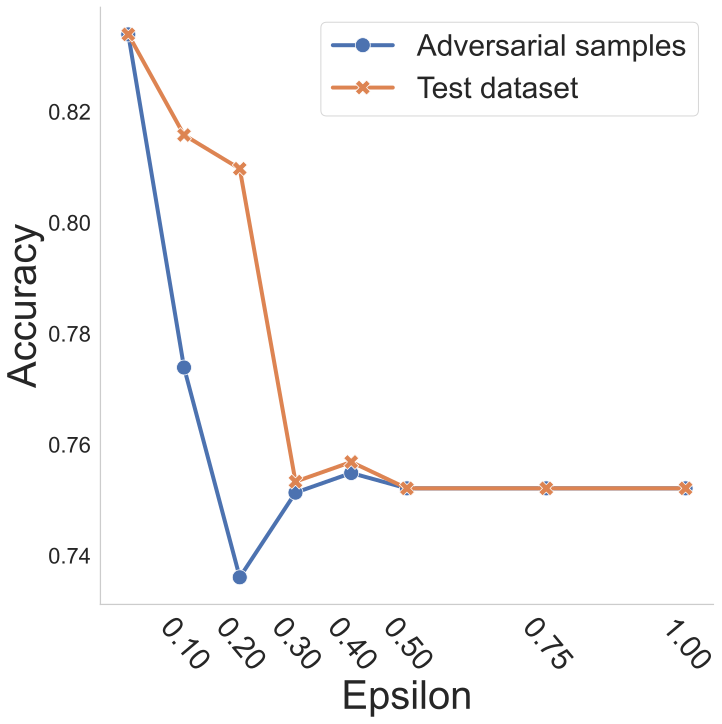

In [36]:
import seaborn

seaborn.set(font_scale=2)
seaborn.set_style("whitegrid", {'axes.grid' : False})

df = pd.DataFrame({
    'epsilon': epsilons,
    'Adversarial samples' : test_accuracies_adv, 
    'Test dataset' : test_accuracies


})
# fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = df.melt(id_vars='epsilon').rename(columns=str.title)
tidy["Samples"] = tidy["Variable"]
tidy["Accuracy"] = tidy["Value"]
# tidy = tidy.rename(columns={"Variable", "Method"})
# seaborn.barplot(x='Epsilon', y='Difference', hue='Method', data=tidy, ax=ax1)

fig, ax1 = plt.subplots(figsize=(11, 11))
p= seaborn.lineplot(data=tidy, x="Epsilon", y="Accuracy", hue="Samples" , style="Samples", linewidth = 4, markers=True, dashes=False, markersize = 15)
p.set_xlabel("Epsilon", fontsize = 40)
p.set_ylabel("Accuracy", fontsize = 40)
p.legend(labels=['Adversarial samples','Test dataset'], fontsize = 30)
plt.xticks(epsilons[1:], rotation = -50,  fontsize = 30)
seaborn.despine(fig)
fig.savefig("./plots/result_1a_1b_norm2.png", bbox_inches='tight')



In [35]:
# Prot 4
print()
import seaborn
import pandas as pd

seaborn.set(font_scale=2)
seaborn.set_style("whitegrid", {'axes.grid' : False})
df = pd.DataFrame({
    'epsilon': epsilons[1:],
    'scfe': [i for i in pd.read_csv("./explanations/costs_scfe_df_{}_4_norm2.csv".format(data_name))["validity"].values],
    'cchvae': [i for i in pd.read_csv("./explanations/costs_cchvae_df_{}_4_norm2.csv".format(data_name))["validity"].values],
    'gsm': [i for i in pd.read_csv("./explanations/costs_gsm_df_{}_4_norm2.csv".format(data_name))["validity"].values]
})
tidy = df.melt(id_vars='epsilon').rename(columns=str.title)
tidy["Method"] = tidy["Variable"]
tidy["Valdity"] = tidy["Value"]
# tidy = tidy.rename(columns={"Variable", "Method"})
# seaborn.barplot(x='Epsilon', y='Difference', hue='Method', data=tidy, ax=ax1)

fig, ax1 = plt.subplots(figsize=(11, 11))
ax1.grid(False)
p= seaborn.lineplot(data=tidy, x="Epsilon", y="Valdity", hue="Method" , style="Method", markers=True, dashes=False, linewidth = 4, markersize = 15)
p.set_xlabel("Epsilon", fontsize = 40)
p.set_ylabel("Valdity", fontsize = 40)
p.legend(labels=["SCFE","C-CHVAE", "GSM"], fontsize = 30)
plt.xticks(epsilons[2:], rotation = -50,  fontsize = 30)
seaborn.despine(fig)
plt.legend(markerscale=2)
fig.savefig("4_b_norm2.png", bbox_inches='tight')  
# fig.savefig("3_b_norm2.png", bbox_inches='tight') 

ValueError: All arrays must be of the same length

In [153]:
# import seaborn
# scfe_values = pd.read_csv("./explanations/valids_scfe_df_{}_3_b.csv".format(data_name))["validity"].values
# cchvae_values = pd.read_csv("./explanations/valids_cchvae_df_{}_3_b.csv".format(data_name))["validity"].values
# gsm_values = pd.read_csv("./explanations/valids_gsm_df_{}_3_b.csv".format(data_name))["validity"].values

# print(scfe_values)

# bin_epsilons = [True]*len(epsilons)
# bin_epsilons[epsilons.index(0.4)] = False
# bin_epsilons[epsilons.index(0.45)] = False

# epsilons_analyse = [epsilons[i] for i in range(1, len(epsilons)) if bin_epsilons[i] == True]
# scfe_values = [scfe_values[i] for i in range(len(scfe_values)) if bin_epsilons[i+1] == True]
# cchvae_values = [cchvae_values[i] for i in range(len(cchvae_values)) if bin_epsilons[i+1] == True]
# gsm_values = [gsm_values[i] for i in range(len(gsm_values)) if bin_epsilons[i+1] == True]

# print(len(epsilons_analyse), len(scfe_values), len(cchvae_values), len(gsm_values))
# # epsilons = [0, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.75, 1.0]

# df = pd.DataFrame({
#     'epsilon': epsilons_analyse,
#     'SCFE': scfe_values,
#     'C-CHVAE': cchvae_values,
#     'GSM': gsm_values
# })
# # fig, ax1 = plt.subplots(figsize=(10, 10))
# tidy = df.melt(id_vars='epsilon').rename(columns=str.title)
# tidy["Method"] = tidy["Variable"]
# tidy["Validity"] = tidy["Value"]
# # tidy = tidy.rename(columns={"Variable", "Method"})
# # seaborn.barplot(x='Epsilon', y='Validity', hue='Method', data=tidy, ax=ax1)
# # seaborn.despine(fig)
# # fig.savefig("valids_3_b.png")  

# fig, ax1 = plt.subplots(figsize=(7, 6))
# p = seaborn.lineplot(data=tidy, x="Epsilon", y="Validity", hue="Method", style="Method", markers=True, dashes=False)
# p.set_xlabel("Epsilon", fontsize = 20)
# p.set_ylabel("Validity", fontsize = 20)
# p.legend(labels=["SCFE","C-CHVAE", "GSM"], fontsize = 20)
# plt.xticks(epsilons[1:], rotation = -50)
# fig.savefig("valids_3_b.png")

[ 3.7200873  5.6871886  7.455351   8.797378  11.620583  25.7369
 19.496183  26.323961  58.814056  61.636402  50.6742   ]


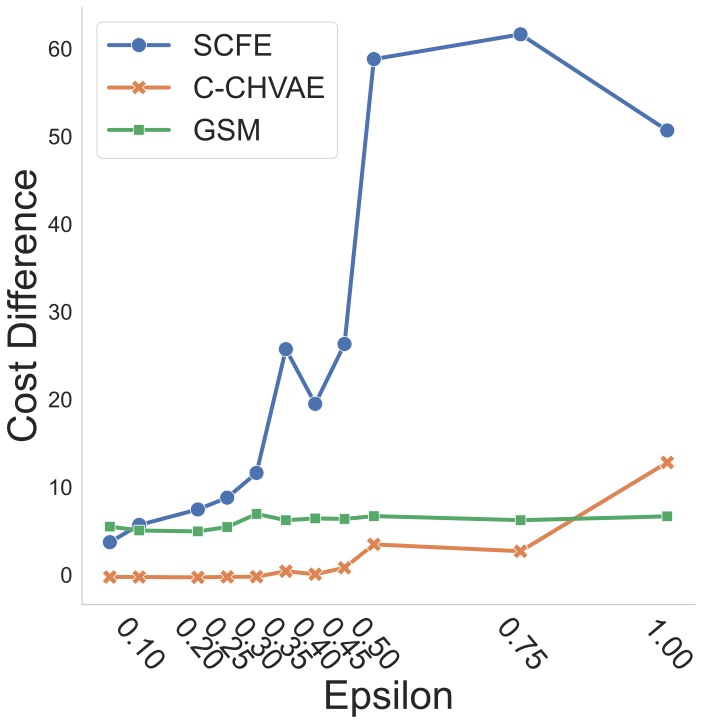

In [18]:
# 3_b

scfe_values = pd.read_csv("./explanations/costs_scfe_df_{}_3_b_norm2.csv".format(data_name))["cost"].values
cchvae_values = pd.read_csv("./explanations/costs_cchvae_df_{}_3_b_norm2.csv".format(data_name))["cost"].values
gsm_values = pd.read_csv("./explanations/costs_gsm_df_{}_3_b_norm2.csv".format(data_name))["cost"].values

print(scfe_values)

bin_epsilons = [True]*len(epsilons)
# bin_epsilons[epsilons.index(0.05)] = False
# bin_epsilons[epsilons.index(0.4)] = False
# bin_epsilons[epsilons.index(0.45)] = False

epsilons_analyse = [epsilons[i] for i in range(1, len(epsilons)) if bin_epsilons[i] == True]
scfe_values = [scfe_values[i] for i in range(len(scfe_values)) if bin_epsilons[i+1] == True]
cchvae_values = [cchvae_values[i] for i in range(len(cchvae_values)) if bin_epsilons[i+1] == True]
gsm_values = [gsm_values[i] for i in range(len(gsm_values)) if bin_epsilons[i+1] == True]


df = pd.DataFrame({
    'epsilon': epsilons_analyse,
    'scfe': scfe_values,
    'cchvae': cchvae_values,
    'gsm': gsm_values
})
# fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = df.melt(id_vars='epsilon').rename(columns=str.title)
tidy["Method"] = tidy["Variable"]
tidy["Cost Difference"] = tidy["Value"]
# tidy = tidy.rename(columns={"Variable", "Method"})
# seaborn.barplot(x='Epsilon', y='Difference', hue='Method', data=tidy, ax=ax1)

fig, ax1 = plt.subplots(figsize=(11, 11))
p= seaborn.lineplot(data=tidy, x="Epsilon", y="Cost Difference", hue="Method" , style="Method", markers=True, dashes=False, linewidth = 4, markersize = 15)
p.set_xlabel("Epsilon", fontsize = 40)
p.set_ylabel("Cost Difference", fontsize = 40)
p.legend(labels=["SCFE","C-CHVAE", "GSM"], fontsize = 30)
plt.xticks(epsilons[2:], rotation = -50, fontsize = 30)
seaborn.despine(fig)

fig.savefig("3_b_norm2.png", bbox_inches='tight')  


In [ ]:
import seaborn
df = pd.DataFrame({
    'epsilon': epsilons[1:],
    'scfe': pd.read_csv("./explanations/costs_scfe_df_{}_3_a.csv".format(data_name))["cost"].values,
    'cchvae': pd.read_csv("./explanations/costs_cchvae_df_{}_3_a.csv".format(data_name))["cost"].values,
    'gsm': pd.read_csv("./explanations/costs_gsm_df_{}_3_a.csv".format(data_name))["cost"].values
})
fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = df.melt(id_vars='epsilon').rename(columns=str.title)
tidy["Method"] = tidy["Variable"]
tidy["Difference"] = tidy["Value"]
# tidy = tidy.rename(columns={"Variable", "Method"})
seaborn.barplot(x='Epsilon', y='Difference', hue='Method', data=tidy, ax=ax1)
seaborn.despine(fig)
fig.savefig("3_b.png")  


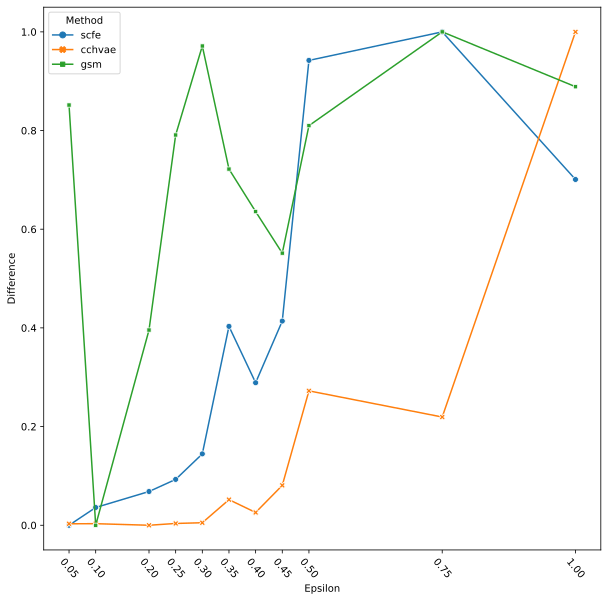

In [49]:
fig, ax1 = plt.subplots(figsize=(10, 10))
seaborn.lineplot(data=tidy, x="Epsilon", y="Difference", hue="Method", style="Method", markers=True, dashes=False)
plt.xticks(epsilons[1:], rotation = -50)
fig.savefig("3_b.pdf")

In [190]:
pd.read_csv("./explanations/costs_scfe_df_{}_3_a.csv".format(data_name))["cost"].values


array([-1.2459134 , -1.1780502 ,  0.88389504,  0.98535043,  0.5547181 ])

In [154]:
# import pickle as pkl
# subset_size = 200
# cchvae_diffs = []
# for epsilon in epsilons:
# #     model_rob = torch.load("./models/{}_lr_model_robust_eps_{}.pth".format(data_name, epsilon))
#     cchvae_costs = pkl.load(open("./explanations/{}_base_cchvae_standard_{}.pkl".format(data_name, epsilon), "rb"))
#     cchvae_diffs.append(cchvae_costs[1])
    